# Day 3, Lecture 1

## MDAnalysis and parallelization

### Global imports:

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis.base import AnalysisBase
import numpy as np
from multiprocessing import Pool, freeze_support
import nglview as nv
import itertools
import sys
import matplotlib.pyplot as plt

As an example of a task that benefits from parallelization we will perform an analysis on a trajectory with thousands of frames. It also happens to be a trajectory that is spread over many individual trajectory files, so you get to try out MDAnalysis' ability to chain multiple readers:

In [2]:
u = mda.Universe('/project/jhlsrf005/JHL_data/Day3-Session1-Practical/md.tpr',
                 '/project/jhlsrf005/JHL_data/Day3-Session1-Practical/md.xtc',
                 '/project/jhlsrf005/JHL_data/Day3-Session1-Practical/md.part0002.xtc',
                 '/project/jhlsrf005/JHL_data/Day3-Session1-Practical/md.part0003.xtc',
                 '/project/jhlsrf005/JHL_data/Day3-Session1-Practical/md.part0004.xtc',
                 '/project/jhlsrf005/JHL_data/Day3-Session1-Practical/md.part0005.xtc',
                 '/project/jhlsrf005/JHL_data/Day3-Session1-Practical/md.part0006.xtc',
                 '/project/jhlsrf005/JHL_data/Day3-Session1-Practical/md.part0007.xtc',)

This is a coarse-grain trajectory of multiple copies of a peptide on a lipid membrane, which is periodic on the _xy_ plane:

In [3]:
# We visualize just the peptides because the entire membrane can get too noisy
peptides = u.select_atoms('protein')
v_peps = nv.show_mdanalysis(peptides)
v_peps

NGLWidget(max_frame=7672)

In [4]:
# We can better visualize a small 100Åx100Å corner of the membrane:
v_small_membrane = nv.show_mdanalysis(u.select_atoms('not resname PW ION and prop x < 100 and prop y < 100'))
v_small_membrane.add_representation("ball+stick", aspectRatio=7.)
v_small_membrane

NGLWidget(max_frame=7672)

One of the lipid types is POPE, which is represented in this coarse-grain model by 13 particles (there are many hundreds of POPE lipids in this system).

![POPE chemical structure](figures/POPE.svg "POPE")

The headgroup is composed by a phosphate particle (name "PO4", represented in orange by `nglview`), and an ethanolamine particle (name "NH3", represented in blue). This headgroup can tilt in response to its environment.

In [5]:
popes = u.select_atoms('resname POPE')
# We take a look at a single POPE residue
v_popes = nv.show_mdanalysis(popes.residues[0].atoms)
v_popes

NGLWidget(max_frame=7672)

### The analysis goal:
- To compute the distribution of the angles of the phosphate-ethanolamine bond with the _z_ axis

<img src="figures/HeadgroupAngle.svg" alt="Headgroup z-angle definition" style="width: 130px;"/>

- To discriminate the behavior between lipids that are close (< 10Å) to a peptide and those that are far away.

- We must take into account the fact that for the bottom leaflet we'll want our distribution to be reversed.

The angle can be computed from the relation between its cosine and the PO4-NH3 vector (**v**):

\begin{equation*}
\cos \alpha = \frac{\mathbf{v_z}}{\left \| \mathbf{v} \right \|}
\end{equation*}

In [6]:
class HeadgroupZAngle(AnalysisBase):
    def __init__(self, peptides, lipids, binwidth=5.0, **kwargs):
        super().__init__(peptides.universe.trajectory, **kwargs)
        self.peptides = peptides
        self.u = self.peptides.universe
        self.lipids = lipids
        self.binwidth = binwidth # The binwidth of the angle distributions
        self.bins = np.arange(0, 180 + self.binwidth, self.binwidth)


    def _prepare(self):
        # The distributions will be histograms between 0 and 180 degrees
        self.results.close_angles = np.zeros(len(self.bins)-1, dtype=int)
        self.results.far_angles = np.zeros(len(self.bins)-1, dtype=int)

        # We need to split the lipid headgroups into top and bottom groups
        #  so that we know for which the angle distribution must be reversed.
        # At the first frame the membrane is quite flat. We can assign
        #  top/bottom leaflets simply by comparing the phosphate position
        #  relative to the membrane's center-of-geometry in z at that frame.
        self.u.trajectory[0]
        membrane_zcog = self.lipids.center_of_geometry()[2]
        self.top_heads = self.lipids.select_atoms('name PO4 NH3 and same residue as '
                                                  f'name PO4 and prop z >= {membrane_zcog}')
        self.bottom_heads = self.lipids.select_atoms('name PO4 NH3 and same residue as '
                                                     f'name PO4 and prop z < {membrane_zcog}')

    def compute_angle(self, headgroups, sign=1):
        # In this topology, NH3 atoms immediately precede PO4 atoms
        pos_nh3 = headgroups.positions[::2]
        pos_po4 = headgroups.positions[1::2]
        vecs = pos_nh3 - pos_po4
        # a correction for vectors crossing the PBC (assumes an orthogonal box)
        vecs += self.u.dimensions[:3]/2
        vecs = mda.lib.distances.apply_PBC(vecs, self.u.dimensions)
        vecs -= self.u.dimensions[:3]/2

        norms = np.linalg.norm(vecs, axis=1)
        angles = sign * np.rad2deg(np.arccos(vecs[:,2]/norms))
        
        # Histogramming the angles over the bins
        dist = np.histogram(angles, bins=self.bins)[0]
        return dist
    
    def _single_frame(self):
        close_heads = self.lipids.select_atoms('name PO4 NH3 and '
                                               'same residue as around 10 global group peptides',
                                                peptides=self.peptides)
        close_heads_top = self.top_heads & close_heads
        close_heads_bottom = self.bottom_heads & close_heads
        far_heads_top = self.top_heads - close_heads_top
        far_heads_bottom = self.bottom_heads - close_heads_bottom
        
        # For each frame we just add up the histograms. We normalize at the end, in _conclude.
        self.results.close_angles += self.compute_angle(close_heads_top)
        self.results.close_angles += self.compute_angle(close_heads_bottom, sign=-1)
        self.results.far_angles += self.compute_angle(far_heads_top)
        self.results.far_angles += self.compute_angle(far_heads_bottom, sign=-1)

    def _conclude(self):
        # Normalization to a probability density
        self.results.close_angles = self.results.close_angles / (self.results.close_angles.sum() * self.binwidth)
        self.results.far_angles = self.results.far_angles / (self.results.far_angles.sum() * self.binwidth)

In [8]:
angle_analysis = HeadgroupZAngle(peptides, popes)

In [ ]:
# Running in serial is perhaps too slow...
# (just interrupt the execution if it takes more than a couple minutes)
angle_analysis.run(verbose=True)

# Parallelization

Let's use Python's `multiprocesing` to spawn multiple children workers to run the analysis per trajectory part.

We use a small function wrapper that takes care of dispatching the right frames to each worker. This example uses an interleaved parallelization that is simple to dispatch, but a block division could also have been implemented.

In [9]:
# The 'parallelize_run' wrapper function will be executed by
#  each child process.
# It takes as arguments the HeagroupZAngle analysis object,
#  the number of workers, and the id of the current worker, which
#  it uses to decide which frames to work on.
def parallelize_run(analysis, n_workers, worker_id):
    # To avoid too many progress bars we only switch verbosity on for
    #  the parallel worker with worker_id == 0
    analysis.run(start=worker_id, step=n_workers, verbose=not worker_id)
    return analysis

# There is a minor incompatibility between forking and the way MDAnalysis
#  outputs the progress bar (https://github.com/MDAnalysis/mdanalysis/issues/3335).
#  It can be solved by having each child process print something (a blank space,
#  in this case) immediately after they are forked.
def display_hack():
    sys.stdout.write(' ')
    sys.stdout.flush()

# This initializes the child processes, using, by default, all the machine's cores.
# Each process then immediately runs, only once, the display_hack function, and
#  is then ready to run functions calls in parallel
pool = Pool(initializer=display_hack)

# We need to build a generator of the set of arguments per worker run,
#  meaning we must repeat the analysis and the number of workers, which
#  we can access via pool._processes.
params = zip(itertools.repeat(angle_analysis),
             itertools.repeat(pool._processes),
             range(pool._processes))

# This is the call that makes each child run the parallelize_run function
analyses = pool.starmap(parallelize_run, params)

# Free the children's resources
pool.close()

Note that the progress bar only reported the frames that were done by worker_id 0. The other workers also did theirs, but this is a simple way to estimate overall progress without having to have many bars at the same time. There are cases where this can report wrong timings: namely, if some workers get frames that are algorithmically heavier, or if there are other concurrent processes in the machine slowing down some of the workers.

### Parallelization as an add-on layer
Note that the extra layer of code needed to implement parallelization was done entirely independently of the already-implemented `HeadgroupZAngle` class and even independently of it's `angle_analysis` instance. This shows the felxibility of this approach to existing analyses.

A final adaptation for parallelization is needed in the collection of the results. `analyses` is now a list with mutliple copies of the same analysis, each run on parts of the trajectory. How the results are collected depends on the analysis. In this case, the results are average histograms over time, so it makes sense to average further between each partial analysis. Because not all workers may have had the same number of frames, we make this an average weighted by each worker's number of frames:

In [10]:
n_frames = [partial_analysis.n_frames for partial_analysis in analyses]

close_angles = np.average([partial_analysis.results.close_angles
                           for partial_analysis in analyses],
                          weights=n_frames,
                          axis=0)

far_angles = np.average([partial_analysis.results.far_angles
                         for partial_analysis in analyses],
                        weights=n_frames,
                        axis=0)

xs = angle_analysis.bins[:-1]
np.savetxt('output_fork_JH.dat', np.column_stack(xs, close_angles, far_angles))

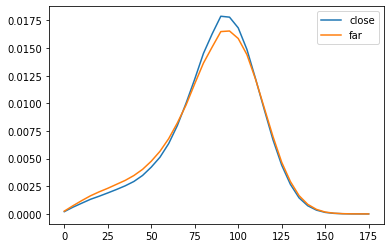

In [13]:
plt.plot(, close_angles, label='close')
plt.plot(analyses[0].bins[:-1], far_angles, label='far')
plt.legend()

# Submitting as a SLURM job

When using an HPC cluster resource you'll likely be running your code from a `.py` script rather than from a Jupyter interface. You then need to submit the execution of that script as a _job_ to the cluster's scheduling queue. In SURF, and in many other HPC centers, the scheduling and execution is handled by a software called _SLURM_.

When a job is submitted, it's execution will take place in one or more of the cluster's computers, and your only feedback will be through logfiles that capture any text the script outputs. Depending on the cluster's availability, and many other factors, execution may only take place hours or even days after submission (for this workshop you're given priority so that queue waiting times are short).

## First things first: converting your notebook to a .py script
Using the terminal:
- navigate to this Practical's directory;
- run `jupyter nbconvert --to script parallelism.ipynb`. This should create a `parallelism.py` script;
- make that script executable by running `chmod +x parallelism.py`.

You can now edit the script using the JupyterHub interface and do the following:
- remove all use of nglview and matplotlib, including the imports (we won't be interested on visual feedback);
- for later comparison of output results, change the saved output file name to `output_fork_SLURM.dat`.

## The submission script and the scheduler
SLURM jobs are typically submitted as Bash jobscripts that take care of initializing environments and managing options to the scheduler. The jobscript then calls the program you want to run (`parallelism.py`, in this case).

You'll find a `jobscript_fork` file doing just that. Lines starting with `#SLURM` indicate options to the scheduler (and their effect is explained in the file).

Environment setup is usually done via module loading, and here we also add a couple of lines to ensure the script finds the workshop's Python environment. When running on your own resources you'll need to adapt this to the particular cluster's environment, and how you were able to get required modules installed. YMMV.

## Submitting and monitoring progress
You can submit the script for execution with

`sbatch jobscript_fork`

This gets the job into the queue. You can then run `squeue -u $USER` to see the status of the job. It will usually either show your job with a status ("ST") of 'R' (Running) or 'PD' (Pending -- while it's waiting in line for execution). You can read more with `man sbatch` and `man squeue`.

When the script ends, the scheduler frees the computing resources for the next job in line. If the requested time is exceeded, SLURM will typically kill your job after a short grace period (though this too depends on actual cluster configuration).

# MPI
MPI enables parallelization over different nodes, but requires a different approach compared to forking. In MPI, all workers ('ranks') start at the same time, before the Universe is even loaded. A strategy is to let only one rank (typically rank 0) do that initial common work, then broadcast the work structures (Analysis and Universe objects) to the other ranks.